# PROJET ATTACK & DEFENSE

## 1. Importations

In [63]:
#!/usr/bin/env python3 
import os
import argparse
import torch
import torchvision
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import copy

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
%cd '/content/drive/MyDrive/Dauphine/M2/Projets DS/Adversarial_attacks'

/content/drive/.shortcut-targets-by-id/1QsCRYdxqNcDFq4i24x8QeUpQnv0EVkZL/Adversarial_attacks


In [8]:
valid_size = 1024 
batch_size = 32

## 2. Basic Net Class

In [9]:

'''Basic neural network architecture (from pytorch doc).'''
class Net(nn.Module):

    model_file="models/default_model.pth"  # The name of the saved model_file can de changed for each network to iterate designs
    '''This file will be loaded to test your model. Use --model-file to load/store a different model.'''

    def __init__(self): #initializes the layers used in the nn
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        x = F.log_softmax(x, dim=1)
        return x

    def save(self, model_file):
        # function used to save the model once trained to './models/default_model.pth'
        # The name of the saved model_file can de changed for each network to iterate designs
        '''Helper function, use it to save the model weights after training.'''
        torch.save(self.state_dict(), model_file)

    def load(self, model_file): #function used to load the saved model in 'test_project.py' and by the teachers online tester
        self.load_state_dict(torch.load(model_file))

        
    def load_for_testing(self, project_dir='./'):
        '''This function will be called automatically before testing your
        project, and will load the model weights from the file
        specify in Net.model_file.

        You must not change the prototype of this function. You may
        add extra code in its body if you feel it is necessary, but
        beware that paths of files used in this function should be
        refered relative to the root of your project directory.
        '''        
        self.load(os.path.join(project_dir, Net.model_file))

net = Net()
net.load_state_dict(torch.load("models/default_model.pth", map_location=torch.device(device)))

<All keys matched successfully>

In [57]:
def train_model(net, train_loader, pth_filename, num_epochs): #pth_filename : path to save the mode
                                                              #train_loader : result of the function get_train_loader 
    print("Starting training")
    
    '''Defining loss'''
    criterion = nn.CrossEntropyLoss()
    '''defining loss function'''
    optimizer = optim.Adam(net.parameters()) 

    for epoch in range(num_epochs):  # loop over the dataset multiple times

        running_loss = 0.0
        
        for i, data in enumerate(train_loader, 0): #loop over the dataset
             # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)

            inputs_adv, _ = attacks.pgd_attack(net, inputs, labels, nn.CrossEntropyLoss(),device, norm='inf') 
            # zero the parameter gradients
            optimizer.zero_grad()

            # forward
            outputs = net(inputs_adv)
            loss = criterion(outputs, labels)
            # backward 
            loss.backward()
            # optimize
            optimizer.step()

            running_loss += loss.item()
        print("Training epoch {} ;   Running Loss = {}".format(epoch+1,running_loss))

    net.save(pth_filename) #save the trained model to the specified model_file="models/..."
    print('Model saved in {}'.format(pth_filename))

## 3. Validation testing function


In [10]:
def test_natural(net, test_loader):
    '''Basic testing function.'''

    correct = 0
    total = 0
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for i,data in enumerate(test_loader, 0):
            images, labels = data[0], data[1]
            # calculate outputs by running images through the network
            outputs = net(images)
            # the class with the highest energy is what we choose as prediction
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return 100 * correct / total

In [41]:
def test_fgsm_attack(net, test_loader, eps=0.03):
    '''FGSM attack testing function.'''
    #print("Test_FGSM_attack, eps={}".format(eps))
    correct = 0
    total = 0

    for batch in test_loader:

        images, labels = batch
        images_adv, labels_adv = fgsm_attack(net, images, labels, nn.CrossEntropyLoss(), eps)
        
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(labels_adv.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    return 100 * correct / total




In [37]:
def test_pgd_attack(net, test_loader, eps=0.03):
    '''PGD attack testing function.'''

    correct = 0
    total = 0

    for batch in test_loader:
        images, labels = batch
        images = images.to(device)
        labels = labels.to(device)
        
        images_adv, labels_adv = pgd_attack(net, images, labels, nn.CrossEntropyLoss(), device, norm='inf', eps=eps)
        
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(labels_adv.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    return 100 * correct / total

## 4. Data loaders

In [13]:
def get_train_loader(dataset, valid_size=1024, batch_size=32):
    '''Split dataset into [train:valid] and return a DataLoader for the training part.'''

    indices = list(range(len(dataset)))
    train_sampler = torch.utils.data.SubsetRandomSampler(indices[valid_size:])
    train = torch.utils.data.DataLoader(dataset, sampler=train_sampler, batch_size=batch_size)

    return train

In [14]:
def get_validation_loader(dataset, valid_size=1024, batch_size=32):
    '''Split dataset into [train:valid] and return a DataLoader for the validation part.'''

    indices = list(range(len(dataset)))
    valid_sampler = torch.utils.data.SubsetRandomSampler(indices[:valid_size])
    valid = torch.utils.data.DataLoader(dataset, sampler=valid_sampler, batch_size=batch_size)

    return valid

## 5. Attacks

### a. FGSM



In [40]:
def fgsm_attack(net, images, labels, criterion=nn.CrossEntropyLoss(), eps=0.03):
    '''
    takes as inputs an image or a batch
    returns (a) perturbed image(s) and the associated preturbed prediction(s)"
    '''

    # Set requires_grad attribute of tensor
    images.requires_grad = True

    # Forward pass
    outputs = net(images)

    # Calculate the loss
    cost = criterion(outputs, labels)

    # Retain the gradient, important for non leaf tensors
    cost.retain_grad() 

    #Zero the gradient 
    net.zero_grad()

    # Backwords pass
    cost.backward()

    # Collect the gradient of the cost wrt images
    image_grad = images.grad.data

    # Create adversarial example
    images_adv = images + eps * image_grad.sign()

    # Re-classify the perturbed images
    labels_adv = net(images_adv)

    return images_adv, labels_adv

### b. PGD

In [29]:
def pgd_attack(net, x, y, loss_fn, device, norm, n_iter=20, step_size=0.01, eps=0.03, clamp=(0,1)):
    '''Take a model , data x and labels y and return '''

    x_adv = x.clone().detach().requires_grad_(True).to(device)
    for i in range(n_iter):
        x_adv_temp = x_adv.clone().detach().requires_grad_(True).to(device)
        pred = net(x_adv_temp)

        loss = loss_fn(pred,y)
        loss.backward()

        with torch.no_grad():

            if norm == 'inf' :
                grad = x_adv_temp.grad.sign() * step_size

            else :
                grad = x_adv_temp.grad * step_size / x_adv_temp.grad.view(x_adv_temp.shape[0], -1).norm(norm, dim=-1).view(-1, x.shape[1], 1, 1)

            x_adv += grad

            if norm == 'inf':
                x_adv = torch.max(torch.min(x_adv, x + eps), x - eps)

            else : 
                delta = x_adv - x

                mask = delta.view(delta.shape[0], -1).norm(norm, dim=1) <= eps

                scaling_factor = delta.view(delta.shape[0], -1).norm(norm, dim=1)
                scaling_factor[mask] = eps

                # .view() assumes batched images as a 4D Tensor
                delta *= eps / scaling_factor.view(-1, 1, 1, 1)

                x_adv = x + delta

        x_adv = x_adv.clamp(*clamp)

    labels_adv = net(x_adv)

    return x_adv.detach(), labels_adv.detach()

## EXPERIMENTATION SECTION

In [17]:
train_transform = transforms.Compose([transforms.ToTensor()]) 
cifar = torchvision.datasets.CIFAR10('./data/', download=True, transform=train_transform)

train_loader = get_train_loader(cifar, valid_size, batch_size=batch_size)
valid_loader = get_validation_loader(cifar, valid_size =valid_size, batch_size=batch_size)

Files already downloaded and verified


In [ ]:
def plot_attacks(loader):
    batch = next(iter(loader))
    images, labels = batch

    # We apply attacks on the data
    images_pgd, labels_pgd = pgd_attack(net, images, labels, nn.CrossEntropyLoss(), device="cpu", norm='inf')
    images_fgsm, labels_fgsm = fgsm_attack(net,images, labels,criterion=nn.CrossEntropyLoss())

    # Attacked predictions
    _, labels_pgd = torch.max(labels_pgd.data, 1)
    _, labels_fgsm = torch.max(labels_fgsm.data, 1)

    # We plot the differents images 
    grid_img = torchvision.utils.make_grid(images[0:3], nrow=3)
    plt.imshow(grid_img.permute(1, 2, 0))
    plt.title('Original data',fontsize=15)
    plt.show()

    grid_img_pgd = torchvision.utils.make_grid(images_pgd[0:3], nrow=3)
    plt.imshow(grid_img_pgd.permute(1, 2, 0))
    plt.title('PGD-attacked data',fontsize=15)
    plt.show()

    grid_img_fgsm = torchvision.utils.make_grid(images_fgsm[0:3], nrow=3)
    plt.imshow(grid_img_fgsm.permute(1, 2, 0))
    plt.title('FGSM-attacked data',fontsize=15)
    plt.show()

    plt.imshow(images[0].detach().permute(1, 2, 0))
    plt.title("True label : {}".format(cifar.classes[labels[0]]))
    plt.show()

    plt.imshow(images_pgd[0].detach().permute(1, 2, 0))
    plt.title("PGD-attacked label : {}".format(cifar.classes[labels_pgd[0]]))
    plt.show()

    plt.imshow(images_fgsm[0].detach().permute(1, 2, 0))
    plt.title("FGSM-attacked label : {}".format(cifar.classes[labels_fgsm[0]]))
    plt.show()

plot_attacks(train_loader)

In [84]:
# helper function to un-normalize and display an image
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image

def display(images, labels_true, labels_pred):
  # plot the images in the batch, along with the corresponding labels
  fig = plt.figure(figsize=(16,16))
  # display 20 images
  for idx in np.arange(24):
    ax = fig.add_subplot(4, 6, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(cifar.classes[labels_pred[idx]], color=('green' if (labels_true[idx] == labels_pred[idx]) else 'red'))
  plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Labels for FGSM-attacked images


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


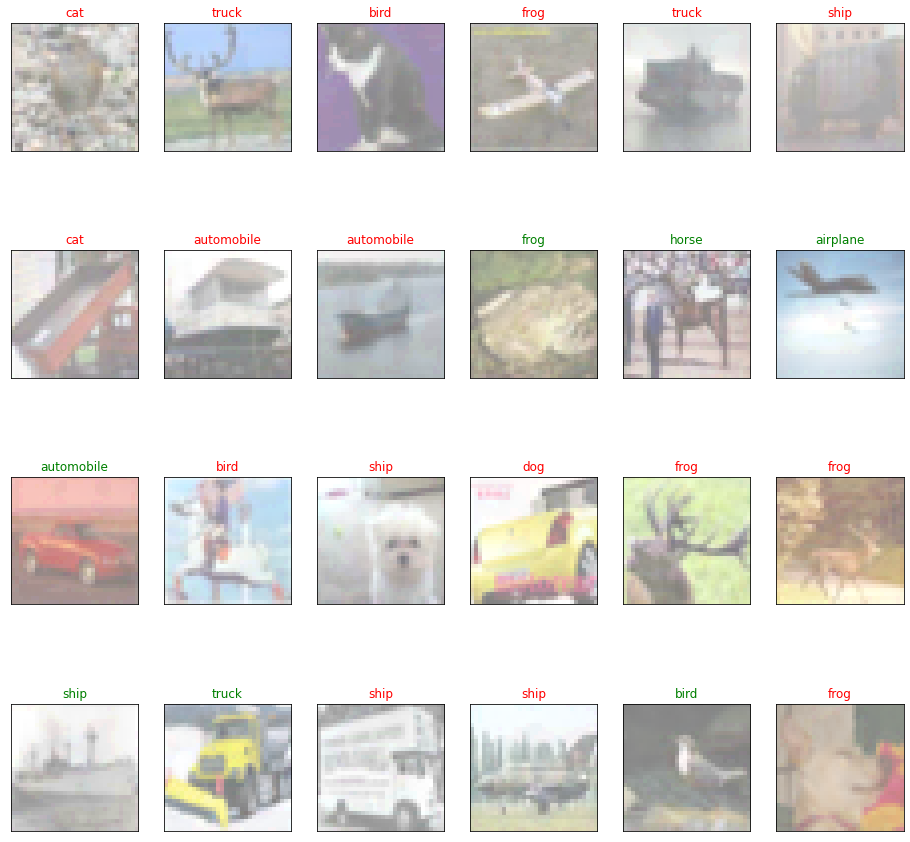

Labels for PGD-attacked images


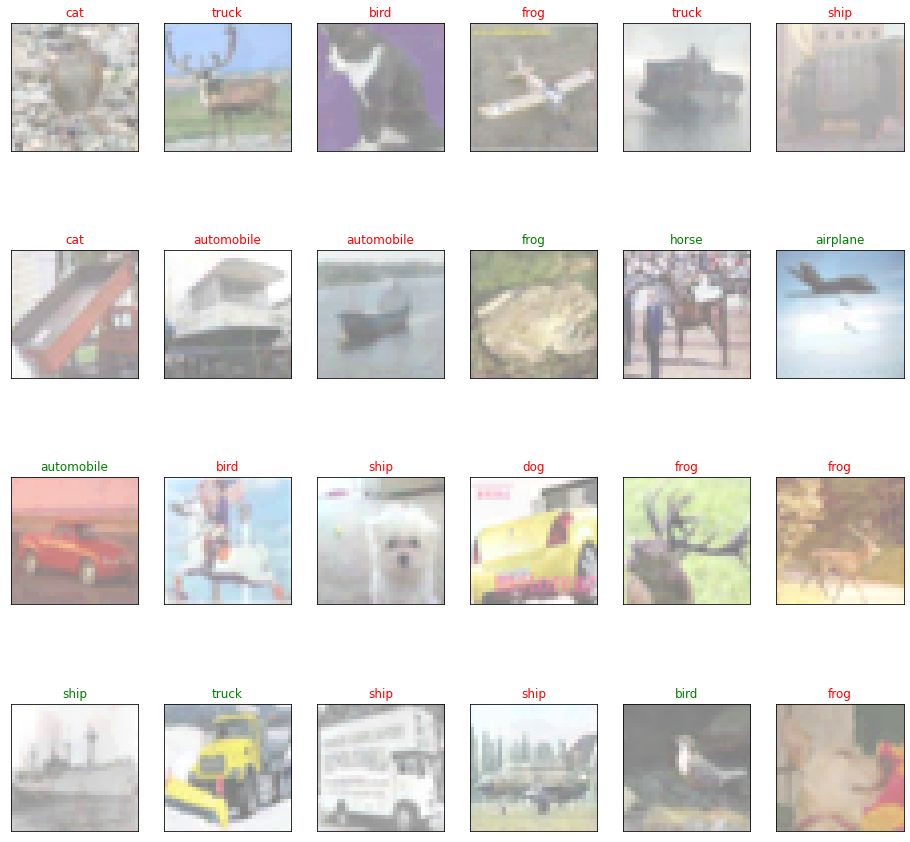

In [85]:
def plot_attacks_labels(loader):
    batch = next(iter(loader))
    images, labels = batch

    # We apply attacks on the data
    #images_nat, labels_nat = 
    images_pgd, labels_pgd = pgd_attack(net, images, labels, nn.CrossEntropyLoss(), device="cpu", norm='inf')
    images_fgsm, labels_fgsm = fgsm_attack(net,images, labels,criterion=nn.CrossEntropyLoss())

    # Attacked predictions
    #_, labels_nat = torch.max(labels_nat.data, 1)
    _, labels_pgd = torch.max(labels_pgd.data, 1)
    _, labels_fgsm = torch.max(labels_fgsm.data, 1)

    #classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


    # We plot the differents images - From the natural nn, fgsm-attacked, pgd-attacked
    images = images.detach().numpy()
    #images_nat = images_nat.detach().numpy()
    images_fgsm = images_fgsm.detach().numpy()
    images_pgd = images_pgd.detach().numpy()
    
    #NATURAL ??

    #FGSM-attacked
    print("Labels for FGSM-attacked images")
    display(images_fgsm, labels, labels_fgsm)

    #PGD-attacked
    print("Labels for PGD-attacked images")
    display(images_pgd, labels, labels_pgd)

plot_attacks_labels(train_loader)

#### Accuracies of the different models

In [19]:
acc = test_natural(net, valid_loader)
print("Model natural accuracy (valid): {} %".format(acc))

fgsm_acc = test_fgsm_attack(net, valid_loader)
print("Model FGSM-attacked accuracy (test): {} %".format(fgsm_acc))

pgd_acc = test_pgd_attack(net, valid_loader)
print("Model PGD-attacked accuracy (test): {} %".format(pgd_acc))


Model natural accuracy (valid): 46.38671875 %
Model FGSM-attacked accuracy (test): 31.15234375 %
Model PGD-attacked accuracy (test): 29.296875 %


#### Plot accuracies wrt eps

0
0.0003
0.001
0.003
0.01
0.03
0.1
0.3
1


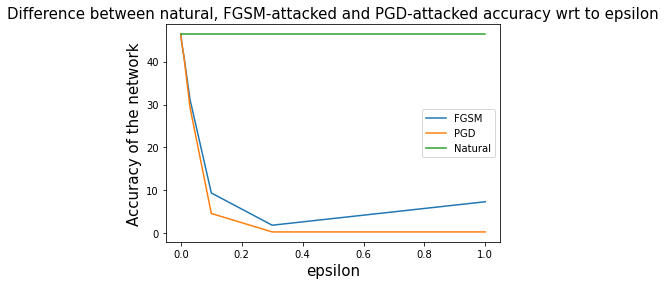

In [42]:
eps = [0, 0.0003 ,0.001 ,0.003 ,0.01 ,0.03 ,0.1 ,0.3 , 1]
adv_FGSM = []
adv_PGD = []
natural = []

for e in eps:
  natural.append( test_natural(net, valid_loader) )

  adv_FGSM.append( test_fgsm_attack(net, valid_loader , eps=e) )

  adv_PGD.append( test_pgd_attack(net, valid_loader, eps=e) )
  print(e)

plt.plot(eps, adv_FGSM, label='FGSM')
plt.plot(eps, adv_PGD, label='PGD')
plt.plot(eps, natural, label='Natural')
plt.xlabel('epsilon', fontsize=15)
plt.ylabel('Accuracy of the network', fontsize=15)
plt.title('Difference between natural, FGSM-attacked and PGD-attacked accuracy wrt to epsilon', fontsize=15)
plt.legend()
plt.show()